In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class GanyuDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.img_files = [os.path.join(root_dir, f)
                          for f in os.listdir(root_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image  # Tidak perlu label

# Transformasi (resize dan normalisasi)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
dataset = GanyuDataset(root_dir="ganyu/ganyu-final", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [2]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256*8*8, bias=False),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256*8*8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)



In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from torch import nn

# Perangkat
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Inisialisasi model
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss dan Optimizer
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Parameter training
epochs = 300
latent_dim = 256
loss_Gs, loss_Ds = [], []

# Buat direktori output
os.makedirs("generated_images", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Training loop
for epoch in range(epochs):
    g_loss_epoch = 0
    d_loss_epoch = 0

    for real_imgs in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Label smoothing + noise
        real_labels = torch.full((batch_size, 1), 0.9).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_labels += 0.05 * torch.rand_like(real_labels)
        fake_labels += 0.05 * torch.rand_like(fake_labels)

        # ======== Train Discriminator ========
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ======== Train Generator ========
        optimizer_G.zero_grad()
        gen_labels = torch.full((batch_size, 1), 0.9).to(device)  # Generator ingin D tertipu
        g_loss = criterion(discriminator(fake_imgs), gen_labels)
        g_loss.backward()
        optimizer_G.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    # Simpan loss per epoch
    loss_Gs.append(g_loss_epoch / len(dataloader))
    loss_Ds.append(d_loss_epoch / len(dataloader))

    print(f"[Epoch {epoch+1}/{epochs}] Loss_D: {loss_Ds[-1]:.4f} | Loss_G: {loss_Gs[-1]:.4f}")

    # Simpan gambar dan model tiap 10 epoch
    if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad():
            test_z = torch.randn(16, latent_dim).to(device)
            sample_imgs = generator(test_z).cpu()
        grid = torchvision.utils.make_grid(sample_imgs, nrow=4, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"Epoch {epoch+1}")
        plt.savefig(f"generated_images/epoch_{epoch+1}.png")
        plt.close()

        torch.save(generator.state_dict(), f"models/generator_epoch_{epoch+1}.pth")

Using device: cuda
[Epoch 1/300] Loss_D: 0.5627 | Loss_G: 3.0033
[Epoch 2/300] Loss_D: 0.4056 | Loss_G: 3.8842
[Epoch 3/300] Loss_D: 0.3937 | Loss_G: 4.0300
[Epoch 4/300] Loss_D: 0.4204 | Loss_G: 4.5403
[Epoch 5/300] Loss_D: 0.4146 | Loss_G: 4.2045
[Epoch 6/300] Loss_D: 0.4159 | Loss_G: 4.4192
[Epoch 7/300] Loss_D: 0.4131 | Loss_G: 4.1076
[Epoch 8/300] Loss_D: 0.4419 | Loss_G: 4.5360
[Epoch 9/300] Loss_D: 0.5956 | Loss_G: 5.2305
[Epoch 10/300] Loss_D: 0.4942 | Loss_G: 4.7590
[Epoch 11/300] Loss_D: 0.6628 | Loss_G: 5.2959
[Epoch 12/300] Loss_D: 0.5827 | Loss_G: 4.4959
[Epoch 13/300] Loss_D: 0.7434 | Loss_G: 3.8330
[Epoch 14/300] Loss_D: 0.5608 | Loss_G: 3.4718
[Epoch 15/300] Loss_D: 0.7129 | Loss_G: 3.3996
[Epoch 16/300] Loss_D: 0.5425 | Loss_G: 3.1286
[Epoch 17/300] Loss_D: 0.6374 | Loss_G: 3.4570
[Epoch 18/300] Loss_D: 0.4968 | Loss_G: 3.0120
[Epoch 19/300] Loss_D: 0.7298 | Loss_G: 3.2413
[Epoch 20/300] Loss_D: 0.5308 | Loss_G: 3.1773
[Epoch 21/300] Loss_D: 0.4599 | Loss_G: 3.2285
[Ep

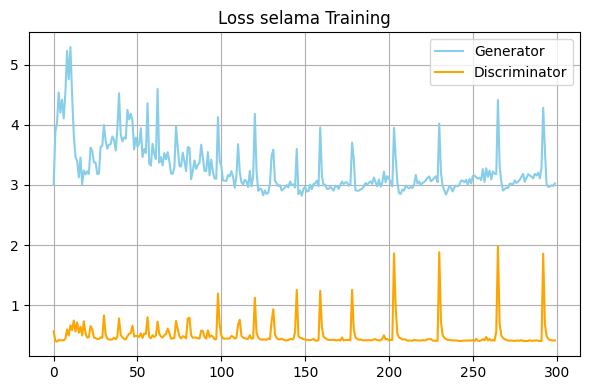

In [4]:
plt.figure(figsize=(6,4))
plt.plot(loss_Gs, label="Generator", color="skyblue")
plt.plot(loss_Ds, label="Discriminator", color="orange")
plt.title("Loss selama Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("generated_images/loss_curve.png")
plt.show()